## We are extracting features from cartoon images. From each image.

In [1]:
from os import listdir
from os import path
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model


def extract_features(directory):
    model = VGG16()
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    model.summary()
    features = dict()
    for name in listdir(directory):
        filename = path.join(directory, name)
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        features[image_id] = feature
        print('>%s' % name)
    return features

# extract features from all images
# directory = '/home/ubuntu/Thesis/Cartoons/499.png'
# features = extract_features(directory)
# print('Extracted Features: %d' % len(features))
# # save to file
# dump(features, open('cartoon_features_final.pkl', 'wb'))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Loading all the user submitted captions for preprocessing.


In [2]:
import string
import re


def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text


def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping

def clean_descriptions(descriptions):
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    for _, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [re_punc.sub('', w) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] =  ' '.join(desc)


def to_vocabulary(descriptions):
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc


def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

filename = '/home/ubuntu/Thesis/Merged_Captions.txt'

doc = load_doc(filename)

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

clean_descriptions(descriptions)

vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

# save_descriptions(descriptions, 'cartoon_descriptions_final.txt')

Loaded: 34 
Vocabulary Size: 3956


In [3]:
from pickle import load


def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text


def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)


def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions


def load_photo_features(filename, dataset):
    all_features = load(open(filename, 'rb'))
    features = {k: all_features[k] for k in dataset}
    return features


filename = '/home/ubuntu/Thesis/photos.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

train_descriptions = load_clean_descriptions('cartoon_descriptions_final.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

train_features = load_photo_features('cartoon_features_final.pkl', train)
print('Photos: train=%d' % len(train_features))

Dataset: 34
Descriptions: train=34
Photos: train=34


In [4]:
def load_clean_descriptions(filename):
    doc = load_doc(filename)
    descriptions = []
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        descriptions.append(image_desc)
    return descriptions

embedding = load_clean_descriptions('cartoon_descriptions_final.txt')

## Creating a word2vec to have word embedding to train out LSTM model

In [5]:
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

word2vec_model = gensim.models.Word2Vec(embedding, min_count=1, size=256, workers=4)

# word2vec_model.wv.save_word2vec_format('/home/ubuntu/Thesis/outfile_seq_embedding')

2018-04-06 18:32:34,461 : INFO : collecting all words and their counts
2018-04-06 18:32:34,462 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-04-06 18:32:34,470 : INFO : collected 3956 word types from a corpus of 19939 raw words and 2315 sentences
2018-04-06 18:32:34,471 : INFO : Loading a fresh vocabulary
2018-04-06 18:32:34,482 : INFO : min_count=1 retains 3956 unique words (100% of original 3956, drops 0)
2018-04-06 18:32:34,483 : INFO : min_count=1 leaves 19939 word corpus (100% of original 19939, drops 0)
2018-04-06 18:32:34,505 : INFO : deleting the raw counts dictionary of 3956 items
2018-04-06 18:32:34,507 : INFO : sample=0.001 downsamples 57 most-common words
2018-04-06 18:32:34,507 : INFO : downsampling leaves estimated 15664 word corpus (78.6% of prior 19939)
2018-04-06 18:32:34,520 : INFO : estimated required memory for 3956 words and 256 dimensions: 10079888 bytes
2018-04-06 18:32:34,521 : INFO : resetting layer weights
2018-04-06 18:32:34,

In [6]:
word2vec_model.wv.save_word2vec_format('/home/ubuntu/Thesis/embedding')

2018-04-06 18:32:34,829 : INFO : storing 3956x256 projection weights into /home/ubuntu/Thesis/embedding


In [7]:
from keras.preprocessing.text import Tokenizer
tokenizer_keras = Tokenizer()
tokenizer_keras.fit_on_texts(train_descriptions)

word_index = tokenizer_keras.word_index

vocab_size = 3958 #len(word_index)
print(vocab_size)

embedding_size = 256

3958


In [8]:
import numpy as np
embedding_matrix = np.zeros((vocab_size+1, embedding_size))

for word,i in word_index.items():
    if word in word2vec_model:
        embedding_vector = word2vec_model[word]
    else:
        embedding_vector = None
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """


In [9]:
embedding_matrix.shape

(3959, 256)

## Defining CNN + LSTM model here for training of our user submitted captions on cartoon images.

Both CNN extracted features and LSTM extracted features are merged and trained together.

In [10]:
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, TimeDistributed
from keras.layers import LSTM, Bidirectional, Conv1D, concatenate, Permute, Dropout


def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

import pdb
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)


def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions


def load_photo_features(filename, dataset):
    all_features = load(open(filename, 'rb'))
    features = {k: all_features[k] for k in dataset}
    return features


def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc


def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)



def define_model(vocab_size, max_length):
    convs = []
    pdb.set_trace()
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(300, activation='relu')(fe1)
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=False, weights= [embedding_matrix], trainable=True)(inputs2)
#     conv1 = Conv1D(128, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform')(se1)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(300)(se2)
#     se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)
#     se4 = Bidirectional(LSTM(256, return_sequences=False))(se3)
#     se5 = Conv1D(128, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform')(se4)
    decoder1 = add([fe2, se3])
#     flat = decoder1.flat
    decoder2 = Dense(128, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model


filename = '/home/ubuntu/Thesis/photos.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('cartoon_descriptions_final.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('cartoon_features_final.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)




Dataset: 34
Descriptions: train=34
Photos: train=34
Vocabulary Size: 3959
Description Length: 40


In [11]:
def create_sequences(tokenizer, max_length, descriptions, photos):
    X1, X2, y = list(), list(), list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            seq = tokenizer.texts_to_sequences([desc])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return array(X1), array(X2), array(y)

In [13]:
# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features)

# Training

In [14]:

# define the model
model = define_model(vocab_size, max_length)

checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
call_back_list = [checkpoint]

model.fit([X1train, X2train], ytrain, epochs=20, verbose=2, callbacks=call_back_list)


> <ipython-input-10-7f5e991946a5>(80)define_model()
-> inputs1 = Input(shape=(4096,))
(Pdb) c
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 256)      1013504     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_1[0][0]                    
_______________

BdbQuit: 

In [14]:
# model.save('/home/ubuntu/Thesis/mine.h5') #bidirectional

In [15]:
# model.save('/home/ubuntu/Thesis/mine_2.h5') #embedding weight initialization

In [14]:
from keras.preprocessing.text import Tokenizer
from pickle import dump


def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text


def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)


def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions


def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc


def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


filename = '/home/ubuntu/Thesis/photos.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

train_descriptions = load_clean_descriptions('cartoon_descriptions_final.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

tokenizer = create_tokenizer(train_descriptions)

dump(tokenizer, open('cartoon_tokenizer_final.pkl', 'wb'))

Dataset: 34
Descriptions: train=34


## Generate caption code

In [122]:
from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model


def extract_features(filename):
    model = VGG16()
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature


def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def cleanup_summary(summary):
    index = summary.find('startseq ')
    if index > -1:
        summary = summary[len('startseq '):]
    index = summary.find(' endseq')
    if index > -1:
        summary = summary[:index]
    return summary


def generate_desc(model, tokenizer, photo, max_length):
    #seed
    in_text = 'we'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text



In [16]:
# model.save('/home/ubuntu/Thesis/last_resort.h5')

In [17]:
# model.save_weights('/home/ubuntu/Thesis/last_resort_weights.h5')

In [18]:
tokenizer = load(open('cartoon_tokenizer_final.pkl', 'rb'))

In [129]:



max_length = 40


photo = extract_features('/home/ubuntu/cartoons_clear/536.jpg')


In [130]:
# model = load_model('/home/ubuntu/Thesis/mine_2.h5')

In [131]:
lstm_model = load_model('/home/ubuntu/Thesis/last_resort.h5') #presenting architecture


In [132]:

# generate
description = generate_desc(lstm_model, tokenizer, photo, max_length) #lstm_model
description = cleanup_summary(description)

In [133]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img=mpimg.imread('/home/ubuntu/cartoons_clear/536.jpg')



# Caption generated for images

we have to stop letting things slide


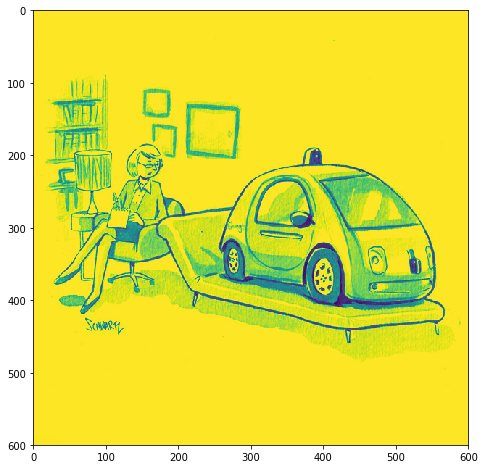

In [134]:
plt.figure(figsize=(20,8))
imgplot = plt.imshow(img)
print(description)